In [1]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import shutil

drive.mount('/content/drive')

chemin_zip = "/content/drive/My Drive/yvanolfotso/dataset/Bell_DNS Dataset.zip"

repertoire_temporaire = "/content/extraction_temp"

# Fonction pour extraire les fichiers zip
def extraire_zip(chemin_zip, repertoire_temporaire):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall(repertoire_temporaire)  # Extraction dans mon répertoire temporaire

# Fonction pour charger et concaténer les fichiers CSV
def charger_concatener_donnees(sous_dossier, prefixe):
    # Lister tous les fichiers CSV dans le sous-dossier
    fichiers_csv = [f for f in os.listdir(f"{repertoire_temporaire}/{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    # Lire chaque fichier CSV et le stocker dans une liste de DataFrames
    dataframes = [pd.read_csv(f"{repertoire_temporaire}/{sous_dossier}/{f}") for f in fichiers_csv]
    # Concaténer les DataFrames en un seul
    return pd.concat(dataframes, ignore_index=True)

# Extraire les fichiers zip
extraire_zip(chemin_zip, repertoire_temporaire)

# Charger et concaténer les données de chaque catégorie
benin_data = charger_concatener_donnees("Bell_DNS Dataset", "features_domain_benign")
malware_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_Malware")
phishing_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_phishing")
spam_data = charger_concatener_donnees("Bell_DNS Dataset", "features-domain_Spam")

# Supprimer le répertoire temporaire après avoir terminé
if os.path.exists(repertoire_temporaire):
    shutil.rmtree(repertoire_temporaire)



Mounted at /content/drive


In [2]:

# Ajout de la colonne 'Class'
benin_data['class'] = 'Benin'
balanced_benign = benin_data.sample(23716, random_state=42)

# Prélèvement d'échantillons pour l'ensemble équilibré
spam_data = spam_data.sample(7643, random_state=42,replace=True)
malware_data = malware_data.sample(7643, random_state=42)
phishing_data = phishing_data.sample(7643, random_state=42)

balanced_samples_malicioux = pd.concat([spam_data, malware_data, phishing_data], ignore_index=True)
balanced_samples_malicioux['class'] = 'Malicioux'

print(balanced_samples_malicioux['class'].value_counts())

# balanced_samples_malicioux = balanced_samples_malicioux.sample(22929, random_state=42)
# print(balanced_samples_malicioux['Class'].value_counts())

print(balanced_benign['class'].value_counts())


final_data = pd.concat([balanced_samples_malicioux,balanced_benign],axis=0, ignore_index=True)


print("\n")
print(" Size all data shape")
print(final_data.shape)



class
Malicioux    22929
Name: count, dtype: int64
class
Benin    23716
Name: count, dtype: int64


 Size all data shape
(46645, 36)


Feature: Unnamed: 34 Information Gain: 0.99979464540737
Feature: char_distribution Information Gain: 0.9984564233185161
Feature: Registrant_Name Information Gain: 0.9966995599480478
Feature: Domain_Name Information Gain: 0.9678890239472411
Feature: distance_from_bad_words Information Gain: 0.9595494696284053
Feature: Creation_Date_Time Information Gain: 0.9585767050281492
Feature: sld Information Gain: 0.954233022326961
Feature: 1gram Information Gain: 0.954233022326961
Feature: 2gram Information Gain: 0.9527873399085403
Feature: 3gram Information Gain: 0.9436766000433775


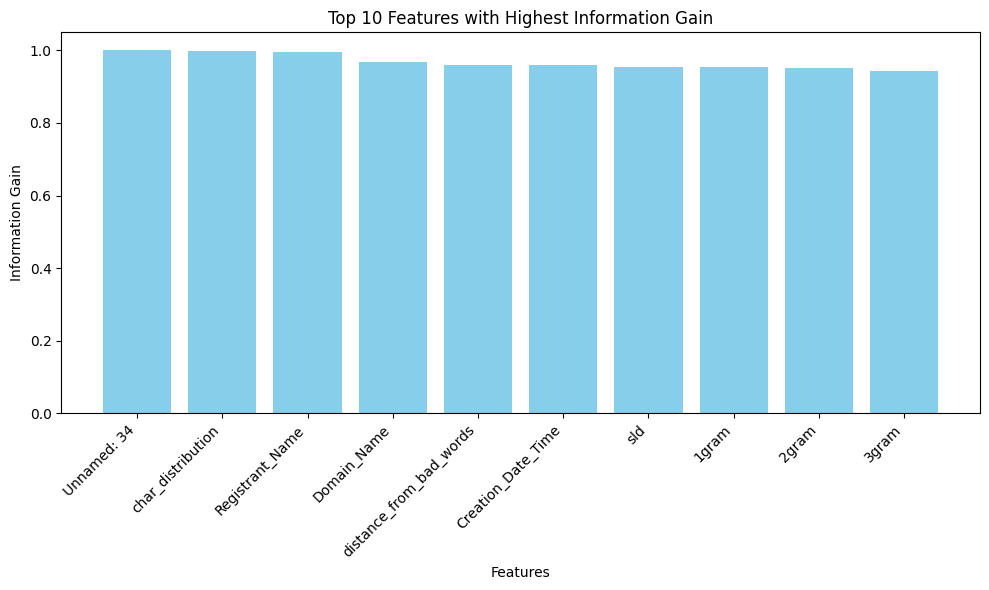

In [3]:
import pandas as pd
from math import log
import matplotlib.pyplot as plt

def entropy(class_probabilities):
    """Calculates the entropy of a list of class probabilities."""
    return sum(-p * log(p, 2) for p in class_probabilities if p)

def information_gain(data, feature_name, classes):
    total_entropy = entropy(data['class'].value_counts(normalize=True))
    values = data[feature_name].unique()
    weighted_entropy = 0.0

    for v in values:
        subset_length = len(data[data[feature_name] == v])
        if subset_length == 0:
            continue  # Skip this value if subset length is zero to avoid division by zero
        subset_entropy = entropy(data[data[feature_name] == v]['class'].value_counts(normalize=True))
        weighted_entropy += (subset_length / len(data)) * subset_entropy

    return total_entropy - weighted_entropy

def calculate_information_gains(data, classes):
    information_gains = []
    total_entropy = entropy(data['class'].value_counts(normalize=True))

    for feature_name in data.columns[:-1]:  # Exclude the last column which is the target variable
        gain = information_gain(data, feature_name, classes)
        information_gains.append((feature_name, gain))

    return information_gains

def select_top_features(data, classes, top_n=10):
    information_gains = calculate_information_gains(data, classes)
    top_features = sorted(information_gains, key=lambda x: x[1], reverse=True)[:top_n]
    return top_features

# data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")

data = final_data

classes = data['class'].unique()

# Calcul du gain d'information pour chaque caractéristique
# information_gains = calculate_information_gains(data, classes)

# Afficher les gains d'information pour chaque caractéristique
# for feature_name, gain in information_gains:
#     print("Information Gain for feature", feature_name, ":", gain)

# Sélectionner les 10 meilleures caractéristiques
top_features = select_top_features(data, classes, top_n=10)

# Afficher les noms des 10 meilleures caractéristiques et leur gain d'information
for feature_name, gain in top_features:
    print("Feature:", feature_name, "Information Gain:", gain)

# Tracer les 10 meilleures caractéristiques
plt.figure(figsize=(10, 6))
plt.bar([x[0] for x in top_features], [x[1] for x in top_features], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Information Gain')
plt.title('Top 10 Features with Highest Information Gain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




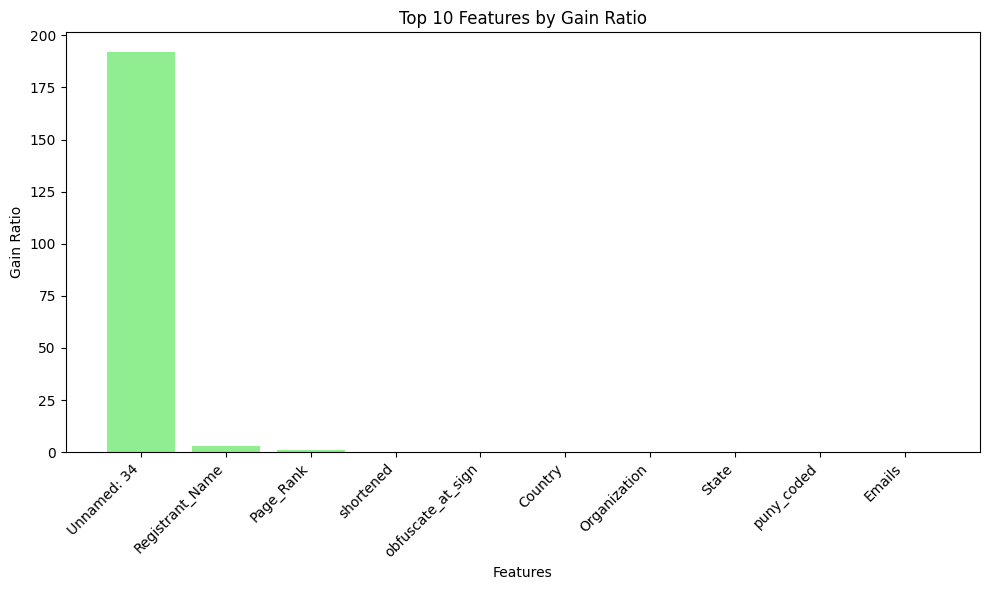

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log

def entropy(class_probabilities):
    """Calculates the entropy of a list of class probabilities."""
    return sum(-p * log(p, 2) for p in class_probabilities if p)

def information_gain(data, feature_name, classes):
    total_entropy = entropy([len(data[data['class'] == c]) / len(data) for c in classes])
    values = data[feature_name].unique()
    weighted_entropy = 0.0

    for v in values:
        subset_length = len(data[data[feature_name] == v])
        if subset_length == 0:
            continue  # Skip this value if subset length is zero to avoid division by zero
        subset_entropy = entropy([len(data[(data[feature_name] == v) & (data['class'] == c)]) / subset_length for c in classes])
        weighted_entropy += (subset_length / len(data)) * subset_entropy

    return total_entropy - weighted_entropy

def calculate_information_gains(data, classes):
    information_gains = []

    for feature_name in data.columns[:-1]:  # Exclude the last column which is the target variable
        gain = information_gain(data, feature_name, classes)
        information_gains.append((feature_name, gain))

    return information_gains

def gain_ratio(data, feature_name, classes):
    gain = information_gain(data, feature_name, classes)
    iv = intrinsic_value(data, feature_name)
    if iv == 0:  # Avoid division by zero
        return 0
    return gain / iv

def intrinsic_value(data, feature_name):
    values = data[feature_name].unique()
    iv = sum(-(len(data[data[feature_name] == v]) / len(data)) * log(len(data[data[feature_name] == v]) / len(data), 2) for v in values if len(data[data[feature_name] == v]) > 0)
    return iv

def select_top_features_with_gain_ratio(data, classes, top_n=10):
    gain_ratios = [(feature_name, gain_ratio(data, feature_name, classes)) for feature_name in data.columns[:-1]]
    top_features = sorted(gain_ratios, key=lambda x: x[1], reverse=True)[:top_n]
    return top_features

def plot_top_features_gain_ratio(top_features, feature_names):
    top_feature_names = [feature_name for feature_name, _ in top_features]
    top_feature_ratios = [ratio for _, ratio in top_features]

    plt.figure(figsize=(10, 6))
    plt.bar(top_feature_names, top_feature_ratios, color='lightgreen')
    plt.xlabel('Features')
    plt.ylabel('Gain Ratio')
    plt.title('Top 10 Features by Gain Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")
data = final_data
classes = data['class'].unique()

# Sélectionner les 10 meilleures caractéristiques avec le ratio de gain
top_features_gain_ratio = select_top_features_with_gain_ratio(data, classes)

# Tracer les 10 meilleures caractéristiques avec le gain ratio
plot_top_features_gain_ratio(top_features_gain_ratio, data.columns[:-1])


In [9]:
# Afficher les noms des 10 meilleures caractéristiques et leur gain d'information
for feature_name, gain in top_features_gain_ratio:
    print("Feature:", feature_name, "Gain Ratio:", gain)

Feature: Unnamed: 34 Gain Ratio: 191.83631309269236
Feature: Registrant_Name Gain Ratio: 3.0036870639107436
Feature: Page_Rank Gain Ratio: 0.9757440184146324
Feature: shortened Gain Ratio: 0.2997415067134265
Feature: obfuscate_at_sign Gain Ratio: 0.2963232635125204
Feature: Country Gain Ratio: 0.16089857782570838
Feature: Organization Gain Ratio: 0.1520470785724435
Feature: State Gain Ratio: 0.1377108140632593
Feature: puny_coded Gain Ratio: 0.1050785956054378
Feature: Emails Gain Ratio: 0.10403109972848708


Top 10 Features with Gini Index:
Feature: Unnamed: 34 , Gini Index: 0.0
Feature: char_distribution , Gini Index: 0.0006187749911621709
Feature: Registrant_Name , Gini Index: 0.0014580375265903635
Feature: Domain_Name , Gini Index: 0.013194061126521947
Feature: distance_from_bad_words , Gini Index: 0.017407289067885905
Feature: Creation_Date_Time , Gini Index: 0.017423715580903276
Feature: sld , Gini Index: 0.01967176105375048
Feature: 1gram , Gini Index: 0.01967176105375048
Feature: 2gram , Gini Index: 0.0204119056622116
Feature: 3gram , Gini Index: 0.024885471733036534


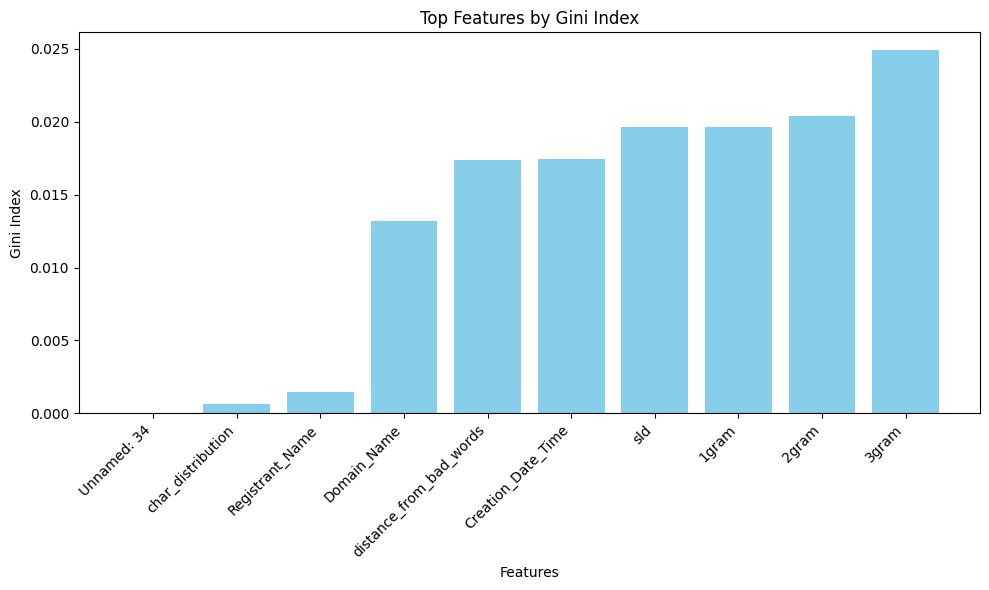

In [5]:
##### Dans ce cas plus la Gini est proche de Zeros plus plus le features est important cas il est pur (ie bon pour la sepration ) ##


import pandas as pd
import matplotlib.pyplot as plt

# Fonctions pour calculer le Gini Index
def gini_index(data, feature_name, classes):
    """Calculates the Gini index for a specific feature."""
    total_instances = len(data)
    values = data[feature_name].unique()
    gini_index_feature = 0.0

    for value in values:
        subset = data[data[feature_name] == value]
        probability = len(subset) / total_instances
        gini_index_feature += probability * gini(subset, classes)

    return gini_index_feature

def gini(data, classes):
    """Calculates the Gini index for a subset of data."""
    total_instances = len(data)
    gini_index_subset = 1.0

    for c in classes:
        num_instances_in_class = len(data[data['class'] == c])
        if num_instances_in_class == 0:
            continue
        probability = num_instances_in_class / total_instances
        gini_index_subset -= probability ** 2

    return gini_index_subset

def select_top_features_with_gini_index(data, classes, top_n=10):
    gini_indices = [(feature_name, gini_index(data, feature_name, classes)) for feature_name in data.columns[:-1]]
    top_features = sorted(gini_indices, key=lambda x: x[1])[:top_n]
    return top_features

# data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")
data = final_data

classes = data['class'].unique()

# Sélectionner les 10 meilleures caractéristiques avec le Gini Index
top_features_gini_index = select_top_features_with_gini_index(data, classes)

# Afficher les noms et les indices de Gini des 10 meilleures caractéristiques
print("Top 10 Features with Gini Index:")
for feature_name, gini_value in top_features_gini_index:
    print("Feature:", feature_name, ", Gini Index:", gini_value)

# Tracer les 10 meilleures caractéristiques avec le Gini Index
def plot_top_features_gini_index(top_features, feature_names):
    top_feature_names = [feature_name for feature_name, _ in top_features]
    top_feature_gini = [gini_value for _, gini_value in top_features]

    plt.figure(figsize=(10, 6))
    colors = ['skyblue' if gini_value > 0 else 'red' for gini_value in top_feature_gini]  # Couleur spéciale pour les Gini Index de zéro
    plt.bar(top_feature_names, top_feature_gini, color=colors)
    plt.xlabel('Features')
    plt.ylabel('Gini Index')
    plt.title('Top Features by Gini Index')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Tracer les 10 meilleures caractéristiques avec le Gini Index
plot_top_features_gini_index(top_features_gini_index, data.columns[:-1])


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Pearson Correlation for each feature:
Domain_Age                      NaN
sld                             NaN
oc_8                            NaN
Emails                          NaN
hex_32                          NaN
Domain_Name                     NaN
puny_coded                 0.085871
Page_Rank                       NaN
Alexa_Rank                      NaN
3gram                           NaN
distance_from_bad_words         NaN
Country                         NaN
hex_8                           NaN
oc_32                      0.002538
len                        0.301714
typos                           NaN
Registrar                       NaN
dec_8                           NaN
2gram                           NaN
State                           NaN
1gram                           NaN
obfuscate_at_sign               NaN
entropy                    0.321202
numeric_percentage         0.209547
Registrant_Name                 NaN
subdomain                       NaN
char_distribution         

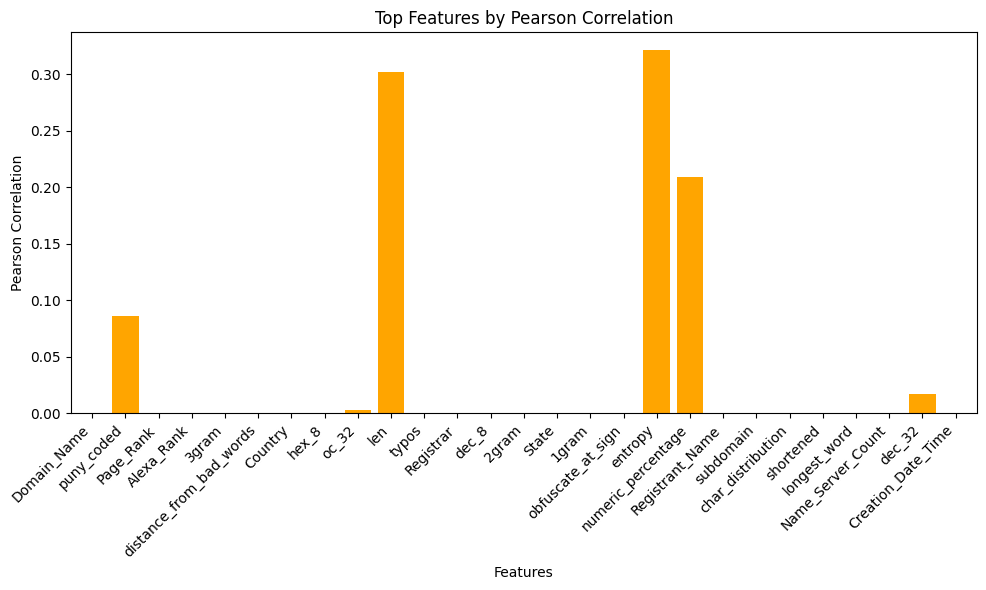

In [6]:
#### Cas ou le Labels n'es pas numerique il faut l'encoder d'abord ##########


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def calculate_pearson_correlation(data):
    # Convertir les étiquettes de classe en valeurs numériques
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(data['class'])

    # Calculer le coefficient de corrélation de Pearson entre chaque caractéristique et la classe
    pearson_correlation = data.iloc[:, :-1].apply(lambda feature: np.abs(np.corrcoef(pd.to_numeric(feature, errors='coerce'), labels_encoded)[0, 1]))

    return pearson_correlation

def plot_top_features_pearson_correlation(pearson_correlation, feature_names):
    plt.figure(figsize=(10, 6))
    colors = ['orange' if correlation > 0 else 'red' for correlation in pearson_correlation]  # Couleur spéciale pour les coefficients de corrélation
    plt.bar(feature_names, pearson_correlation, color=colors)
    plt.xlabel('Features')
    plt.ylabel('Pearson Correlation')
    plt.title('Top Features by Pearson Correlation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")

data = final_data

# Calculer les coefficients de corrélation de Pearson
pearson_correlation = calculate_pearson_correlation(data)

# Afficher les coefficients de corrélation de Pearson pour chaque caractéristique
print("Pearson Correlation for each feature:")
print(pearson_correlation)

# Afficher les caractéristiques avec leur coefficient de corrélation de Pearson
plot_top_features_pearson_correlation(pearson_correlation, data.columns[:-1])


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def calculate_pearson_correlation(data):
    # Convertir les étiquettes de classe en valeurs numériques
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(data['class'])

    # Calculer le coefficient de corrélation de Pearson entre chaque caractéristique et la classe
    pearson_correlation = data.iloc[:, :-1].apply(lambda feature: np.abs(np.corrcoef(pd.to_numeric(feature, errors='coerce'), labels_encoded)[0, 1]))

    return pearson_correlation

# data = pd.read_csv("../data/BenignAndMaliciousDataset.csv")

data = final_data

# Calculer les coefficients de corrélation de Pearson
pearson_correlation = calculate_pearson_correlation(data)

# Afficher les coefficients de corrélation de Pearson pour chaque caractéristique
print("Pearson Correlation for each feature:")
print(pearson_correlation)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Pearson Correlation for each feature:
Domain_Age                      NaN
sld                             NaN
oc_8                            NaN
Emails                          NaN
hex_32                          NaN
Domain_Name                     NaN
puny_coded                 0.085871
Page_Rank                       NaN
Alexa_Rank                      NaN
3gram                           NaN
distance_from_bad_words         NaN
Country                         NaN
hex_8                           NaN
oc_32                      0.002538
len                        0.301714
typos                           NaN
Registrar                       NaN
dec_8                           NaN
2gram                           NaN
State                           NaN
1gram                           NaN
obfuscate_at_sign               NaN
entropy                    0.321202
numeric_percentage         0.209547
Registrant_Name                 NaN
subdomain                       NaN
char_distribution         